In [141]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import os
import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst

# Visualization
from src.visualization import visualization as viz

# Models
from src.modeling import modeling
import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error

# REMINDER - OBJECTIVE
In the previous [notebook](4_Modeling.ipynb), XGBoost model has been tried with few parameters tuned through a GridSearch. It gave us the best results but we have seen that there was high overfitting.  
Here the goal is to **keep moving forward on parameters tuning and try to reduce overfitting** with some parameters made for that in addition with the use of the earlystopping functionnality.  
We will **also use the validation dataset** as evaluation one so that we have train, validation for metric evaluation and earlystopping and then the test dataset.

# 1. Load datasets

In [2]:
X_train = pd.read_csv(datacollector.get_data_file(cst.LST_X_TRAIN_FILE, True), sep=',', header=0)
y_train = pd.read_csv(datacollector.get_data_file(cst.LST_Y_TRAIN_FILE, True), sep=',', header=None)
X_val = pd.read_csv(datacollector.get_data_file(cst.LST_X_VAL_FILE, True), sep=',', header=0)
y_val = pd.read_csv(datacollector.get_data_file(cst.LST_Y_VAL_FILE, True), sep=',', header=None)
X_test = pd.read_csv(datacollector.get_data_file(cst.LST_X_TEST_FILE, True), sep=',', header=0)
y_test = pd.read_csv(datacollector.get_data_file(cst.LST_Y_TEST_FILE, True), sep=',', header=None)

y_train.columns = ['train_price']
y_val.columns = ['val_price']
y_test.columns = ['test_price']

In [3]:
print("X_train.shape is {}".format(X_train.shape))
print("y_train.shape is {}".format(y_train.shape))
print("X_val.shape is {}".format(X_val.shape))
print("y_val.shape is {}".format(y_val.shape))
print("X_test.shape is {}".format(X_test.shape))
print("y_test.shape is {}".format(y_test.shape))

X_train.shape is (52076, 153)
y_train.shape is (52076, 1)
X_val.shape is (5787, 153)
y_val.shape is (5787, 1)
X_test.shape is (6430, 153)
y_test.shape is (6430, 1)


---
# 2. RandomizedSearchCV instead of classic GridSearchCV
### 2.1. First run
See documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) for more details and examples about RandomizedSearchCV.  
Explore values for `reg_alpha` parameter which is a regularization one.

In [5]:
# Parameters of xgboost that may change
param_grid = {
    'n_estimators': [100, 200, 300], # Number of estimators (weak learners)
    'min_child_weight': [4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.1],
    'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6, 10)], # subsample ratio of columns when constructing each tree (range is [0, 1])
    'reg_alpha': [0.02, 0.03, 0.04, 0.1, 1], # L1 regularization term on weights. Increasing this value will make model more conservative
    'max_depth': [5, 6, 7]  # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
}

xgb_randomsearch = modeling.build_xgb_random_search(param_grid, num_iters=40)

In [6]:
y_xgbrs_run1 = modeling.fit_and_run_pipeline(xgb_randomsearch, 'tuned and optimized xgboost', X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 72.8min finished


RMSE for tuned and optimized xgboost model on train: 90.87
RMSE for tuned and optimized xgboost model on test: 102.38


**Observations:**
* **No significant improvement for RMSE value on test dataset**
* but we can see that there is less difference between train and test so I think **we managed to reduce** a little bit the **overfitting**.
* It seems to be really difficult to reduce this RMSE value which remains high. Perhaps this is the **best we can achieve with this number of estimators** (our best one has 300 which is the highest value given in the parameters grid). **We should try to increase this value**.

### 2.2. Feature importances

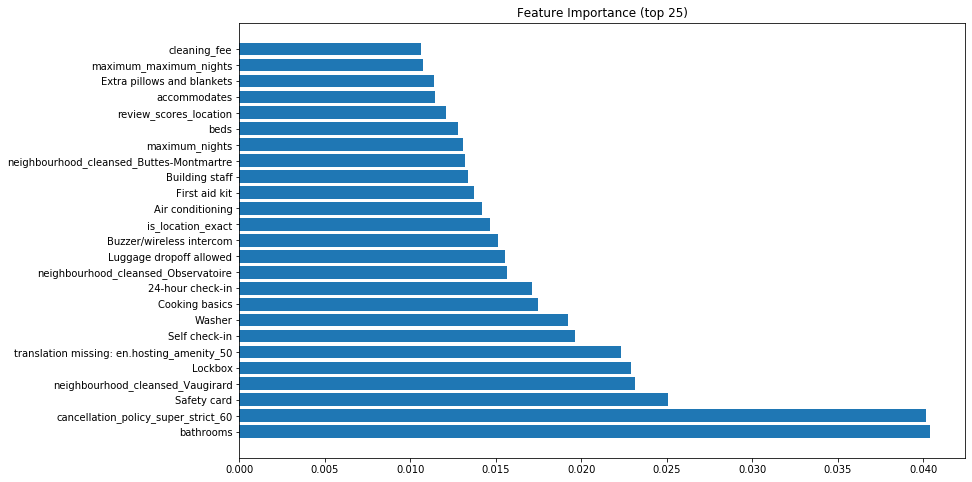

In [9]:
viz.plot_feature_importances(xgb_randomsearch.best_estimator_.feature_importances_, X_test.columns.tolist())

**Observations**:
* We find again the `cancellation_policy_super_strict_60` that the basic DecisionTree found as well but now `bathrooms` is as important.
* Less `neighbourhoods` in this TOP 25 (Vaugirard, Montmartre) and more amenities
* `Safety card` is still here (3rd)

###  2.3. Results comparison table & error analysis
To have a better intuition on how 'accurate' our models were, I will concatenate all predictions for our models and compare that to the ground truth. This results file will be saved so that it can be loaded later for further investigations.

In [10]:
results_df = pd.concat([y_test, pd.DataFrame(data=y_xgbrs_run1)],axis=1)
results_df.columns = ['y_true', 'y_xgbrs_run1']
results_df.head(20)

,y_true,y_xgbrs_run1
0,59.0,63.762135
1,90.0,80.044769
2,46.0,55.033432
3,67.0,90.333168
4,59.0,84.442856
5,95.0,108.445274
6,90.0,78.571976
7,119.0,514.855530
8,90.0,130.405289
9,65.0,77.177063


**Observation:** even if value are different, at first glance, it seems that predictions are more or less the "same" than previous results.  
Let's classify also to have a better understanding.

In [11]:
results_df = modeling.classify_results(results_df, 'y_xgbrs_run1')

In [12]:
results_df.head()

,y_true,y_xgbrs_run1,y_xgbrs_run1_perc_diff,y_xgbrs_run1_perc_diff_class
0,59.0,63.762135,8.07,3-good (5% < x < 10%)
1,90.0,80.044769,11.06,4-acceptable (10% < x < 20%)
2,46.0,55.033432,19.64,4-acceptable (10% < x < 20%)
3,67.0,90.333168,34.83,5-bad (20% < x < 40%)
4,59.0,84.442856,43.12,6-awful (> 40%)


In [15]:
results_df['y_xgbrs_run1_perc_diff_class'].value_counts().sort_index()

1-very accurate (< 2%)           332
2-pretty good (2% < x < 5%)      483
3-good (5% < x < 10%)            837
4-acceptable (10% < x < 20%)    1402
5-bad (20% < x < 40%)           1854
6-awful (> 40%)                 1522
Name: y_xgbrs_run1_perc_diff_class, dtype: int64

***Observation:*** classes 1 to 4 (included) counts for 47.5% of the dataset, we are still in the same proportions.  
Let's try another approach.

---
# 3. Use python API (not the sklearn one)
As said several times now, when using xgboost through its sklearn wrapper API, the xgboost's built-in `'earlystopping'` function cannot be used with GridSearchCV. There are few posts on the Internet talking about that (for example [here](https://discuss.xgboost.ai/t/how-to-do-early-stopping-with-scikit-learns-gridsearchcv/151) or [there](https://stackoverflow.com/questions/50824326/xgboost-with-gridsearchcv-scaling-pca-and-early-stopping-in-sklearn-pipeline)). One workaround is to use the xgboost built-in `cv` function and do the grid search by ourselves.

The following section has been developped by following this [tutorial](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f) and also this [other one](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/). Both articles describe the same approach, more or less, which is:
1. Choose a relatively high learning rate and determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2. Tune tree-specific parameters (`max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`) for decided learning rate and number of trees.
3. Tune regularization parameters (`lambda`, `alpha`) for xgboost which can help reduce model complexity and enhance performance.
4. Lower the learning rate and decide the optimal parameters. 

(source: [here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/))

### 3.1. Transform datasets into DMatrices

In [ ]:
# XGBoost has native handling of missing values and if nothing is given then np.nan is the value which is taken according to
# the documentation here: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbregressor#module-xgboost.core
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

### 3.2. Set parameters grid to default values

In [152]:
# Parameters of xgboost that may change
params = {   
    # Defines the minimum sum of weights of all observations required in a child.
    # Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific
    # to the particular sample selected for a tree.
    # [default=1]
    'min_child_weight': 1,
    
    # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
    'max_depth': 6,
    
    # Gamma: A node is split only when the resulting split gives a positive reduction in the loss function.
    # Gamma specifies the minimum loss reduction required to make a further partition on a leaf node of the tree.
    # Makes the algorithm conservative.
    'gamma': 0,
    
    # Learning rate
    'eta': .3,
    
    # Denotes the fraction of observations to be randomly samples for each tree.
    # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to 
    # under-fitting. Typical values: 0.5-1
    # [default=1] means we use all rows
    'subsample': 1,
    
    # Subsample ratio of columns when constructing each tree (range is [0, 1])
    # [default=1] means we use all columns/features
    'colsample_bytree': 1,
    
    # L1 regularization term on weights. Increasing this value will make model more conservative
    # Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
    # [default=0]
    'alpha': 0, 
    
    # L2 regularization term on weights
    # Increasing this value will make model more conservative.
    # [default=1]
    'lambda': 1,
    
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric': 'rmse'
}

model = xgb.train(params, dtrain, num_boost_round=999, evals=[(dval, "Validation")], early_stopping_rounds=30)

[0]	Validation-rmse:162.661
Will train until Validation-rmse hasn't improved in 30 rounds.
[1]	Validation-rmse:142.142
[2]	Validation-rmse:130.15
[3]	Validation-rmse:121.947
[4]	Validation-rmse:117.891
[5]	Validation-rmse:114.193
[6]	Validation-rmse:112.642
[7]	Validation-rmse:113.364
[8]	Validation-rmse:114.35
[9]	Validation-rmse:113.557
[10]	Validation-rmse:113.224
[11]	Validation-rmse:112.405
[12]	Validation-rmse:111.495
[13]	Validation-rmse:111.207
[14]	Validation-rmse:110.848
[15]	Validation-rmse:110.84
[16]	Validation-rmse:113.274
[17]	Validation-rmse:113.242
[18]	Validation-rmse:112.986
[19]	Validation-rmse:112.599
[20]	Validation-rmse:112.552
[21]	Validation-rmse:111.985
[22]	Validation-rmse:111.978
[23]	Validation-rmse:111.952
[24]	Validation-rmse:114.198
[25]	Validation-rmse:115.955
[26]	Validation-rmse:115.854
[27]	Validation-rmse:115.776
[28]	Validation-rmse:115.791
[29]	Validation-rmse:117.009
[30]	Validation-rmse:120.145
[31]	Validation-rmse:119.856
[32]	Validation-rmse:1

In [153]:
model.best_score, model.best_iteration, model.best_ntree_limit

(110.840141, 15, 16)

It works as expected, the training stopped after 10 rounds without improvement of the given metric.

### 3.3. Tuning `max_depth` and `min_child_weight`
* ***max_depth***: maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
* ***min_child_weight***: Defines the minimum sum of weights of all observations required in a child. Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.

In [73]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in [5, 6, 7, 8] 
    for min_child_weight in [1, 2, 3, 4, 5, 6]
]
param_names = ['max_depth', 'min_child_weight']

In [74]:
modeling.find_best_parameters(dtrain, params, gridsearch_params, param_names, 10)

CV run for parameters:
	max_depth: 5	min_child_weight: 1
	RMSE value: 130.68 for 26 rounds
CV run for parameters:
	max_depth: 5	min_child_weight: 2
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	max_depth: 5	min_child_weight: 3
	RMSE value: 131.03 for 43 rounds
CV run for parameters:
	max_depth: 5	min_child_weight: 4
	RMSE value: 132.12 for 37 rounds
CV run for parameters:
	max_depth: 5	min_child_weight: 5
	RMSE value: 131.71 for 51 rounds
CV run for parameters:
	max_depth: 5	min_child_weight: 6
	RMSE value: 132.07 for 37 rounds
CV run for parameters:
	max_depth: 6	min_child_weight: 1
	RMSE value: 131.72 for 16 rounds
CV run for parameters:
	max_depth: 6	min_child_weight: 2
	RMSE value: 130.59 for 21 rounds
CV run for parameters:
	max_depth: 6	min_child_weight: 3
	RMSE value: 132.31 for 31 rounds
CV run for parameters:
	max_depth: 6	min_child_weight: 4
	RMSE value: 131.89 for 31 rounds
CV run for parameters:
	max_depth: 6	min_child_weight: 5
	RMSE value: 131.62 for 48 rounds

### 3.4. Tuning `gamma`
* ***gamma***: node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

In [154]:
gridsearch_params = [0, 0.5, 1, 5, 10, 20, 30]
param_names = ['gamma']

In [155]:
modeling.find_best_parameters(dtrain, params, gridsearch_params, param_names, 20)

CV run for parameters:
	gamma: 0
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	gamma: 0.5
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	gamma: 1
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	gamma: 5
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	gamma: 10
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	gamma: 20
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	gamma: 30
	RMSE value: 129.30 for 40 rounds
Best params['gamma']: [30], RMSE value: 129.30


Changing `gamma` value does not seem to have an impact, this is weird. Even if the cross validation gives 30 as the best result, I will keep the default value as results are the same.

### 3.5. Tuning `subsample` and `colsample_bytree`
* ***subsample***: denotes the fraction of observations to be randomly samples for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
* ***colsample_bytree***: Subsample ratio of columns when constructing each tree

In [96]:
gridsearch_params = [
    (subsample, colsample_bytree)
    for subsample in [i/10.0 for i in range(6, 11)]
    for colsample_bytree in [i/10.0 for i in range(6, 11)]
]

param_names = ['subsample', 'colsample_bytree']

In [98]:
modeling.find_best_parameters(dtrain, params, gridsearch_params, param_names, 30)

CV run for parameters:
	subsample: 0.6	colsample_bytree: 0.6
	RMSE value: 134.76 for 17 rounds
CV run for parameters:
	subsample: 0.6	colsample_bytree: 0.7
	RMSE value: 135.19 for 24 rounds
CV run for parameters:
	subsample: 0.6	colsample_bytree: 0.8
	RMSE value: 135.18 for 20 rounds
CV run for parameters:
	subsample: 0.6	colsample_bytree: 0.9
	RMSE value: 135.81 for 35 rounds
CV run for parameters:
	subsample: 0.6	colsample_bytree: 1.0
	RMSE value: 134.29 for 40 rounds
CV run for parameters:
	subsample: 0.7	colsample_bytree: 0.6
	RMSE value: 133.40 for 21 rounds
CV run for parameters:
	subsample: 0.7	colsample_bytree: 0.7
	RMSE value: 135.77 for 16 rounds
CV run for parameters:
	subsample: 0.7	colsample_bytree: 0.8
	RMSE value: 132.75 for 28 rounds
CV run for parameters:
	subsample: 0.7	colsample_bytree: 0.9
	RMSE value: 133.24 for 34 rounds
CV run for parameters:
	subsample: 0.7	colsample_bytree: 1.0
	RMSE value: 132.87 for 41 rounds
CV run for parameters:
	subsample: 0.8	colsample_b

### 3.6. Tuning `alpha` and `lambda`
* ***alpha***: denotes the fraction of observations to be randomly samples for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
* ***lambda***: Subsample ratio of columns when constructing each tree

In [99]:
gridsearch_params = [
    (alpha, reg_lambda)
    for alpha in [0.02, 0.03, 0.04, 0.1, 1]
    for reg_lambda in [1, 3, 5]
]

param_names = ['alpha', 'lambda']

In [100]:
modeling.find_best_parameters(dtrain, params, gridsearch_params, param_names, 10)

CV run for parameters:
	alpha: 0.02	lambda: 1
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	alpha: 0.02	lambda: 3
	RMSE value: 130.35 for 61 rounds
CV run for parameters:
	alpha: 0.02	lambda: 5
	RMSE value: 129.41 for 71 rounds
CV run for parameters:
	alpha: 0.03	lambda: 1
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	alpha: 0.03	lambda: 3
	RMSE value: 130.35 for 61 rounds
CV run for parameters:
	alpha: 0.03	lambda: 5
	RMSE value: 129.41 for 71 rounds
CV run for parameters:
	alpha: 0.04	lambda: 1
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	alpha: 0.04	lambda: 3
	RMSE value: 130.35 for 61 rounds
CV run for parameters:
	alpha: 0.04	lambda: 5
	RMSE value: 129.41 for 71 rounds
CV run for parameters:
	alpha: 0.1	lambda: 1
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	alpha: 0.1	lambda: 3
	RMSE value: 130.34 for 61 rounds
CV run for parameters:
	alpha: 0.1	lambda: 5
	RMSE value: 129.46 for 70 rounds
CV run for parameters:
	alpha: 1	lambda: 1


It seems that `alpha` has no impact whereas `lambda` has a little one because there is a pattern:
* RMSE = 129.30 when lambda=1
* RMSE = 130.34 when lambda=3
* RMSE = 129.41 when lambda=5

### 3.7. Tuning `eta`
* ***eta***: it corresponds to the learning rate. Lower values will increase our number of trees.

In [148]:
gridsearch_params = [.3, .2, .1, .05, .01, .005]
param_names = ['eta']

In [149]:
modeling.find_best_parameters(dtrain, params, gridsearch_params, param_names, 10)

CV run for parameters:
	eta: 0.3
	RMSE value: 129.30 for 40 rounds
CV run for parameters:
	eta: 0.2
	RMSE value: 129.61 for 90 rounds
CV run for parameters:
	eta: 0.1
	RMSE value: 128.06 for 201 rounds
CV run for parameters:
	eta: 0.05
	RMSE value: 127.32 for 327 rounds
CV run for parameters:
	eta: 0.01
	RMSE value: 128.40 for 998 rounds
CV run for parameters:
	eta: 0.005
	RMSE value: 129.94 for 998 rounds
Best params['eta']: [0.05], RMSE value: 127.32


### 3.8. Putting it all together
After all cross validation runs, our best parameters to use are:

In [157]:
params

{'min_child_weight': 2,
 'max_depth': 5,
 'gamma': 0,
 'eta': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'alpha': 0.1,
 'lambda': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

Let's now fit and predict with such parameters. We will use 328 rounds (given by last cv run for `eta`).

In [161]:
best_model = xgb.train(params, dtrain, num_boost_round=328, evals=[(dval, "Validation")], early_stopping_rounds=10)

[0]	Validation-rmse:189.412
Will train until Validation-rmse hasn't improved in 10 rounds.
[1]	Validation-rmse:183.97
[2]	Validation-rmse:179.007
[3]	Validation-rmse:174.205
[4]	Validation-rmse:169.865
[5]	Validation-rmse:165.522
[6]	Validation-rmse:161.736
[7]	Validation-rmse:158.058
[8]	Validation-rmse:154.753
[9]	Validation-rmse:151.597
[10]	Validation-rmse:148.662
[11]	Validation-rmse:145.911
[12]	Validation-rmse:143.275
[13]	Validation-rmse:140.834
[14]	Validation-rmse:138.393
[15]	Validation-rmse:136.453
[16]	Validation-rmse:134.603
[17]	Validation-rmse:132.764
[18]	Validation-rmse:131.143
[19]	Validation-rmse:129.659
[20]	Validation-rmse:128.128
[21]	Validation-rmse:126.657
[22]	Validation-rmse:125.417
[23]	Validation-rmse:124.262
[24]	Validation-rmse:123.198
[25]	Validation-rmse:121.988
[26]	Validation-rmse:121.007
[27]	Validation-rmse:120.102
[28]	Validation-rmse:119.151
[29]	Validation-rmse:118.391
[30]	Validation-rmse:117.549
[31]	Validation-rmse:116.817
[32]	Validation-rmse

In [168]:
y_xgb_run_py_api_train = best_model.predict(dtrain)
print("RMSE for XGBoost tuned with internal cv on train: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_xgb_run_py_api_train))))

RMSE for XGBoost tuned with internal cv on train: 114.85


In [162]:
y_xgb_run_py_api = best_model.predict(dtest)
print("RMSE for XGBoost tuned with internal cv on test: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_xgb_run_py_api))))

RMSE for XGBoost tuned with internal cv on test: 104.42



---
# 4. Another RandomizedSearch with more values
## 4.1. Build parameter grid and launch search
Let's try to increase the number of estimators and explore more values.

As the `validation` dataset is not used with RandomSearch, we are losing some interesting data. The idea here is to rebuild a bigger `train` dataset and use it for the RandomSearch.

In [104]:
y_val.columns = ['train_price']
X_train2 = pd.concat([X_train, X_val], axis=0)
y_train2 = pd.concat([y_train, y_val], axis=0)
print("X_train2.shape is {}".format(X_train2.shape))
print("y_train2.shape is {}".format(y_train2.shape))

X_train2.shape is (57863, 153)
y_train2.shape is (57863, 1)


In [106]:
# Parameters of xgboost that may change
param_grid = {
    'n_estimators': [100, 300, 500, 700, 800], # Number of estimators (weak learners)
    
    # Defines the minimum sum of weights of all observations required in a child.
    # Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific
    # to the particular sample selected for a tree.
    # [default=1]
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    
    # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
    'max_depth': [5, 6, 7, 8],
    
    # Gamma: A node is split only when the resulting split gives a positive reduction in the loss function.
    # Gamma specifies the minimum loss reduction required to make a further partition on a leaf node of the tree.
    # Makes the algorithm conservative.
    'gamma': [i/10.0 for i in range(0, 7)],
    
    # Learning rate
    'learning_rate': [.3, .2, .1, .05, .01, .005],
    
    # Denotes the fraction of observations to be randomly samples for each tree.
    # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to 
    # under-fitting. Typical values: 0.5-1
    # [default=1]
    'subsample': [i/10.0 for i in range(6, 11)],
    'colsample_bytree': [i/10.0 for i in range(6, 11)], # subsample ratio of columns when constructing each tree (range is [0, 1])
    
    # L1 regularization term on weights. Increasing this value will make model more conservative
    # Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
    # [default=0]
    'reg_alpha': [0.02, 0.03, 0.04, 0.1, 1], 
    
    # L2 regularization term on weights
    # Increasing this value will make model more conservative.
    # [default=1]
    'reg_lambda': [1, 3, 5]
}

xgb_randomsearch2 = modeling.build_xgb_random_search(param_grid, num_iters=100)
y_xgbrs_run2 = modeling.fit_and_run_pipeline(xgb_randomsearch2, 'tuned and optimized xgboost', X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 105.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 279.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 317.1min finished


RMSE for tuned and optimized xgboost model on train: 30.43
RMSE for tuned and optimized xgboost model on test: 101.88


***Observation:*** there is still overfitting but it seems we have found a better combination for parameters.  
Let's display what were our best estimator.

In [108]:
xgb_randomsearch2.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0.6, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=7, min_child_weight=2, missing=None,
             n_estimators=800, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0.1,
             reg_lambda=3, scale_pos_weight=1, seed=42, silent=None,
             subsample=1.0, verbose=False, verbosity=1)

## 4.2. Refit with earlystopping
First, we do not activate the earlystopping.

In [134]:
model = xgb_randomsearch2.best_estimator_.fit(X_train, y_train, verbose=False,
                                              eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse')

#### Display learning curves

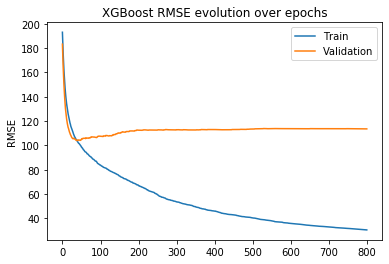

In [137]:
viz.plot_learning_curves(model)

In [138]:
model_es = xgb_randomsearch2.best_estimator_.fit(X_train, y_train, verbose=False,
                                              eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
                                             early_stopping_rounds=10)

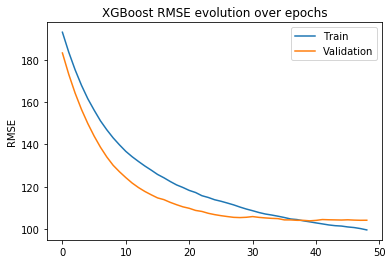

In [139]:
viz.plot_learning_curves(model_es)

In [169]:
y_xgbrs_run_with_es_train = model_es.predict(X_train)
print("RMSE for XGBoost with early stopping model on train: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_xgbrs_run_with_es_train))))

RMSE for XGBoost with early stopping model on train: 103.43


In [142]:
y_xgbrs_run_with_es = model_es.predict(X_test)
print("RMSE for XGBoost with early stopping model on test: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_xgbrs_run_with_es))))

RMSE for XGBoost with early stopping model on test: 101.09


The early stopping function works as expected and we can clearly see that there is no need to have a lot of estimators (trees), the more we add the more it overfits without improvement on validation set. Results are even slightly better.

---
## 5. Results comparison
Let's concatenate all our predictions into a new dataframe so that we can compare them. We have:
* ***y_true***: the real price
* ***y_xgbrs_run_light***: (xgboost sklearn wrapper) prediction with RandomizedSearch 'light' (400 fits)
* ***y_xgbrs_run_full***: (xgboost sklearn wrapper) prediction with RandomizedSearch and more values to explore (500 fits)
* ***y_xgbrs_run_with_es***: (xgboost sklearn wrapper) the best model found with run full + earlystopping
* ***y_xgb_run_py_api***: (xgboost internal python api) best model found after parameters tuning then run with earlystopping

In [165]:
results_df = pd.concat([y_test, 
                        pd.DataFrame(data=y_xgbrs_run1), 
                        pd.DataFrame(data=y_xgbrs_run2), 
                        pd.DataFrame(data=y_xgbrs_run_with_es),
                        pd.DataFrame(data=y_xgb_run_py_api)],
                       axis=1)
results_df.columns = ['y_true', 'y_xgbrs_run_light', 'y_xgbrs_run_full', 'y_xgbrs_run_with_es', 'y_xgb_run_py_api']
results_df.head(10)

,y_true,y_xgbrs_run_light,y_xgbrs_run_full,y_xgbrs_run_with_es,y_xgb_run_py_api
0,59.0,63.762135,62.879246,65.232857,67.108482
1,90.0,80.044769,85.548782,74.711510,77.864044
2,46.0,55.033432,54.515701,59.607632,58.642143
3,67.0,90.333168,85.936150,95.750923,98.538551
4,59.0,84.442856,77.867317,81.731850,88.702660
5,95.0,108.445274,101.893532,104.948822,110.145081
6,90.0,78.571976,76.608368,77.621010,80.645348
7,119.0,514.855530,536.258850,524.725891,404.656189
8,90.0,130.405289,103.199371,121.328766,129.756149
9,65.0,77.177063,71.133011,68.866974,74.254250


In [166]:
results_df = modeling.classify_results(results_df, 'y_xgbrs_run_light')
results_df = modeling.classify_results(results_df, 'y_xgbrs_run_full')
results_df = modeling.classify_results(results_df, 'y_xgbrs_run_with_es')
results_df = modeling.classify_results(results_df, 'y_xgb_run_py_api')

In [167]:
results_df.head(10)

,y_true,y_xgbrs_run_light,y_xgbrs_run_full,y_xgbrs_run_with_es,y_xgb_run_py_api,y_xgbrs_run_light_perc_diff,y_xgbrs_run_light_perc_diff_class,y_xgbrs_run_full_perc_diff,y_xgbrs_run_full_perc_diff_class,y_xgbrs_run_with_es_perc_diff,y_xgbrs_run_with_es_perc_diff_class,y_xgb_run_py_api_perc_diff,y_xgb_run_py_api_perc_diff_class
0,59.0,63.762135,62.879246,65.232857,67.108482,8.07,3-good (5% < x < 10%),6.57,3-good (5% < x < 10%),10.56,4-acceptable (10% < x < 20%),13.74,4-acceptable (10% < x < 20%)
1,90.0,80.044769,85.548782,74.711510,77.864044,11.06,4-acceptable (10% < x < 20%),4.95,2-pretty good (2% < x < 5%),16.99,4-acceptable (10% < x < 20%),13.48,4-acceptable (10% < x < 20%)
2,46.0,55.033432,54.515701,59.607632,58.642143,19.64,4-acceptable (10% < x < 20%),18.51,4-acceptable (10% < x < 20%),29.58,5-bad (20% < x < 40%),27.48,5-bad (20% < x < 40%)
3,67.0,90.333168,85.936150,95.750923,98.538551,34.83,5-bad (20% < x < 40%),28.26,5-bad (20% < x < 40%),42.91,6-awful (> 40%),47.07,6-awful (> 40%)
4,59.0,84.442856,77.867317,81.731850,88.702660,43.12,6-awful (> 40%),31.98,5-bad (20% < x < 40%),38.53,5-bad (20% < x < 40%),50.34,6-awful (> 40%)
5,95.0,108.445274,101.893532,104.948822,110.145081,14.15,4-acceptable (10% < x < 20%),7.26,3-good (5% < x < 10%),10.47,4-acceptable (10% < x < 20%),15.94,4-acceptable (10% < x < 20%)
6,90.0,78.571976,76.608368,77.621010,80.645348,12.70,4-acceptable (10% < x < 20%),14.88,4-acceptable (10% < x < 20%),13.75,4-acceptable (10% < x < 20%),10.39,4-acceptable (10% < x < 20%)
7,119.0,514.855530,536.258850,524.725891,404.656189,332.65,6-awful (> 40%),350.64,6-awful (> 40%),340.95,6-awful (> 40%),240.05,6-awful (> 40%)
8,90.0,130.405289,103.199371,121.328766,129.756149,44.89,6-awful (> 40%),14.67,4-acceptable (10% < x < 20%),34.81,5-bad (20% < x < 40%),44.17,6-awful (> 40%)
9,65.0,77.177063,71.133011,68.866974,74.254250,18.73,4-acceptable (10% < x < 20%),9.44,3-good (5% < x < 10%),5.95,3-good (5% < x < 10%),14.24,4-acceptable (10% < x < 20%)


### RMSE and classification table results
As a reminder and to have a better view on improvement and progression, previous results are given here as well.  

| Model              | RMSE value on train | RMSE value on test | Nb class 1-very accurate (< 2%) | Nb class 2-pretty good (2% < x < 5%) | Nb class 3-good (5% < x < 10%) | Nb class 4-acceptable (10% < x < 20%) | Nb class 5-bad (20% < x < 40%) | Nb class 6-awful (> 40%) |
|--------------------|---------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
| Naive              | N/A                 | 138.02             | 148             | 240             | 453             | 727             | 1280             | 3582             |
| Linear Regression  | 141.72              | 113.43             | 219             | 326             | 526             | 1086             | 1696             | 2577             |
| Basic DecisionTree | 104.85              | 186.95             | 273             | 417             | 637             | 1161             | 1788             | 2154             |
| Tuned DecisionTree | 125.43              | 114.46             | 301             | 393             | 632             | 1120             | 1847             | 2137             |
| XGBoost (1st try)  | 40.59               | 102.73             | 347             | 515             | 864             | 1409             | 1816             | 1479             |
| XGBoost (RS Light) | 90.87               | 102.38             | 332             | 483             | 837             | 1402             | 1854             | 1522             |
| XGBoost (RS Full)  | 30.43               | 101.88             | 331             | 518             | 824             | 1444             | 1821             | 1492             |
| XGBoost (Full + ES)| 103.43              | 101.09             | 312             | 483             | 735             | 1320             | 1887             | 1693             |
| XGBoost (Py API )  | 114.85              | 104.42             | 300             | 453             | 745             | 1287             | 1847             | 1798             |


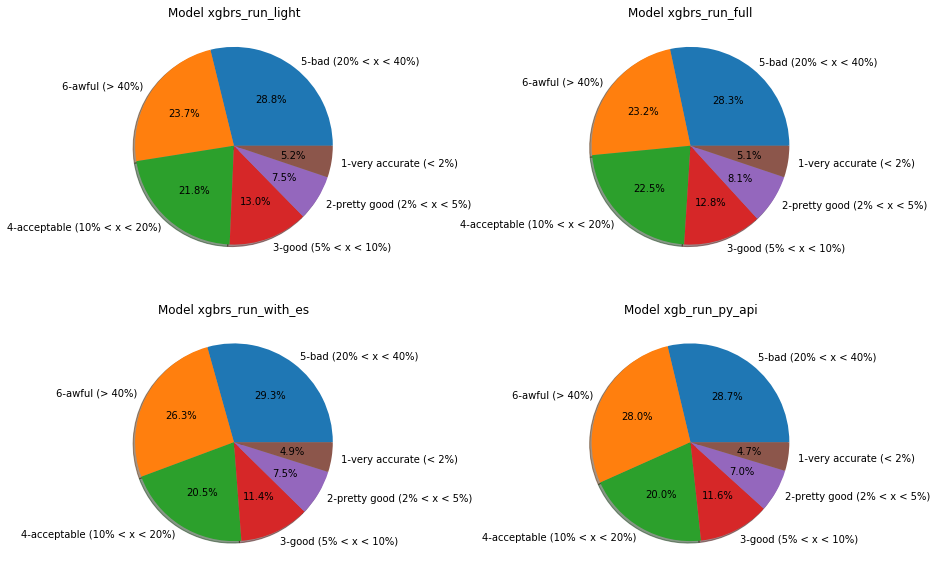

In [174]:
model_names = ['xgbrs_run_light', 'xgbrs_run_full', 'xgbrs_run_with_es', 'xgb_run_py_api']
viz.plot_classification_results_pie(model_names, results_df)

---

# CONCLUSION
In spite of all the efforts made for paramters tuning (and there are a lot with XGBoost), I was not unable to improve significantly the results I got with the first try and even if I found a combination that slightly improved the RMSE value, when analyzing in more details the first XGBoost remains the best choice as it is with it that most of the prices are near the truth.  
Even if it is quite frustrating not having improved the results, let's recall that the first goal of this project was to show our ability to follow the Datascience process CRISP-DM and this is what has been done:
1. `Data Understanding` in the [1st notebook](1_Data_Understanding.ipynb)
2. `Business Understanding` in the [2nd one](2_Business_Understanding.ipynb) with also some checks against the online service.
3. `Data preparation` [here](3_Data_Preparation.ipynb)
4. `Modeling`, tuning and `Evaludation` (this notebook and the [previous one](4_Modeling.ipynb))

It remains the `Deployment` (or `Exposition`) phase that will be done through a blog post.  
And let's say that to see the glass half full, we were able to build a model with 80% price prediction accuracy half the time. Naive model was 80% precision 25% of the time and linear regression 33% of the time.

To go further and still try to improve, here are some things one could do:
* Try Bayesian Optimization with [scikit-optimize](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html) to provide search space and see if it gives better results.
* Try [Catboost](https://catboost.ai/) from the russian company Yandex (as we have a lot of categorical features) and they say that there is less parameter tuning.
* Check if dimensionnality reduction (with PCA) could help us.
* Perform feature engineering by building new features.
* Create ensemble of models, stack them to average the results.